#### Packages

In [2]:
import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops
import numpy as np
import random
try:
    import cPickle  # Python 2.7
except ImportError:
    import pickle as cPickle  # Python 3 compatibility
    
import re
import matplotlib.pyplot as plt

import pandas as pd
import os

#### Data Loader

In [3]:
class Gen_Data_loader():

    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.token_stream = []

    def create_batches(self, data_file):
        self.token_stream = []
        with open(data_file, 'r') as f:
            for line in f:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                if len(parse_line) == 20:
                    self.token_stream.append(parse_line)

        self.num_batch = int(len(self.token_stream) / self.batch_size)
        self.token_stream = self.token_stream[:self.num_batch * self.batch_size]
        self.sequence_batch = np.split(np.array(self.token_stream), self.num_batch, 0)
        self.pointer = 0

    def next_batch(self):
        ret = self.sequence_batch[self.pointer]
        self.pointer = (self.pointer + 1) % self.num_batch
        return ret

    def reset_pointer(self):
        self.pointer = 0


class Dis_dataloader():

    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.sentences = np.array([])
        self.labels = np.array([])

    def load_train_data(self, positive_file, negative_file):
        # Load data
        positive_examples = []
        negative_examples = []

        with open(positive_file)as fin:
            for line in fin:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                positive_examples.append(parse_line)

        with open(negative_file)as fin:
            for line in fin:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                if len(parse_line) == 20:
                    negative_examples.append(parse_line)

        self.sentences = np.array(positive_examples + negative_examples)

        # Generate labels
        positive_labels = [[0, 1] for _ in positive_examples]
        negative_labels = [[1, 0] for _ in negative_examples]
        self.labels = np.concatenate([positive_labels, negative_labels], 0)

        # Shuffle the data
        shuffle_indices = np.random.permutation(np.arange(len(self.labels)))
        self.sentences = self.sentences[shuffle_indices]
        self.labels = self.labels[shuffle_indices]

        # Split batches
        self.num_batch = int(len(self.labels) / self.batch_size)
        self.sentences = self.sentences[:self.num_batch * self.batch_size]
        self.labels = self.labels[:self.num_batch * self.batch_size]
        self.sentences_batches = np.split(self.sentences, self.num_batch, 0)
        self.labels_batches = np.split(self.labels, self.num_batch, 0)

        self.pointer = 0

    def next_batch(self):
        ret = self.sentences_batches[self.pointer], self.labels_batches[self.pointer]
        self.pointer = (self.pointer + 1) % self.num_batch
        return ret

    def reset_pointer(self):
        self.pointer = 0


#### Generator

In [4]:

class Generator(object):
    
    def __init__(self, num_emb, batch_size, emb_dim, hidden_dim,
                 sequence_length, start_token,
                 learning_rate=0.01, reward_gamma=0.95):
        
        self.num_emb = num_emb                                                                  # Vocabulary Size
        self.batch_size = batch_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = tf.constant([start_token] * self.batch_size, dtype=tf.int32)
        self.learning_rate = tf.Variable(float(learning_rate), trainable=False)
        self.reward_gamma = reward_gamma
        self.g_params = []
        self.d_params = []
        self.temperature = 1.0
        self.grad_clip = 5.0

        self.expected_reward = tf.Variable(tf.zeros([self.sequence_length]))

        with tf.variable_scope('generator'):
            self.g_embeddings = tf.Variable(self.init_matrix([self.num_emb, self.emb_dim]))
            self.g_params.append(self.g_embeddings)
            self.g_recurrent_unit = self.create_recurrent_unit(self.g_params)  # maps h_tm1 to h_t for generator
            self.g_output_unit = self.create_output_unit(self.g_params)  # maps h_t to o_t (output token logits)

        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator
        self.rewards = tf.placeholder(tf.float32, shape=[self.batch_size, self.sequence_length]) # get from rollout policy and discriminator

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        # Initial states
        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        gen_o = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)
        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        def _g_recurrence(i, x_t, h_tm1, gen_o, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.num_emb, 1.0, 0.0),
                                                             tf.nn.softmax(o_t)), 1))  # [batch_size] , prob
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, gen_o, gen_x

        _, _, _, self.gen_o, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, gen_o, gen_x))

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

        # supervised pretraining for generator
        g_predictions = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length,
            dynamic_size=False, infer_shape=True)

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        def _pretrain_recurrence(i, x_t, h_tm1, g_predictions):
            h_t = self.g_recurrent_unit(x_t, h_tm1)
            o_t = self.g_output_unit(h_t)
            g_predictions = g_predictions.write(i, tf.nn.softmax(o_t))  # batch x vocab_size
            x_tp1 = ta_emb_x.read(i)
            return i + 1, x_tp1, h_t, g_predictions

        _, _, _, self.g_predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.sequence_length,
            body=_pretrain_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token),
                       self.h0, g_predictions))

        self.g_predictions = tf.transpose(self.g_predictions.stack(), perm=[1, 0, 2])  # batch_size x seq_length x vocab_size

        # pretraining loss
        self.pretrain_loss = -tf.reduce_sum(
            tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                tf.clip_by_value(tf.reshape(self.g_predictions, [-1, self.num_emb]), 1e-20, 1.0)
            )
        ) / (self.sequence_length * self.batch_size)

        # training updates
        pretrain_opt = self.g_optimizer(self.learning_rate)

        self.pretrain_grad, _ = tf.clip_by_global_norm(tf.gradients(self.pretrain_loss, self.g_params), self.grad_clip)
        self.pretrain_updates = pretrain_opt.apply_gradients(zip(self.pretrain_grad, self.g_params))

        #######################################################################################################
        #  Unsupervised Training
        #######################################################################################################
        
        # POLICY LOSS
        self.g_loss = -tf.reduce_sum(
            tf.reduce_sum(
                tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                    tf.clip_by_value(tf.reshape(self.g_predictions, [-1, self.num_emb]), 1e-20, 1.0)
                ), 1) * tf.reshape(self.rewards, [-1])
        )

        g_opt = self.g_optimizer(self.learning_rate)

        self.g_grad, _ = tf.clip_by_global_norm(tf.gradients(self.g_loss, self.g_params), self.grad_clip)
        self.g_updates = g_opt.apply_gradients(zip(self.g_grad, self.g_params))

    def generate(self, sess):
        outputs = sess.run(self.gen_x)
        return outputs

    def pretrain_step(self, sess, x):
        outputs = sess.run([self.pretrain_updates, self.pretrain_loss], feed_dict={self.x: x})
        return outputs

    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)

    def init_vector(self, shape):
        return tf.zeros(shape)

    def create_recurrent_unit(self, params):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Ui = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bi = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wf = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uf = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bf = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wog = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uog = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bog = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wc = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uc = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bc = tf.Variable(self.init_matrix([self.hidden_dim]))
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wog, self.Uog, self.bog,
            self.Wc, self.Uc, self.bc])

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self, params):
        self.Wo = tf.Variable(self.init_matrix([self.hidden_dim, self.num_emb]))
        self.bo = tf.Variable(self.init_matrix([self.num_emb]))
        params.extend([self.Wo, self.bo])

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def g_optimizer(self, *args, **kwargs):
        return tf.train.AdamOptimizer(*args, **kwargs)


#### Discriminator

In [5]:
# An alternative to tf.nn.rnn_cell._linear function, which has been removed in Tensorfow 1.0.1
# The highway layer is borrowed from https://github.com/mkroutikov/tf-lstm-char-cnn

def linear(input_, output_size, scope=None):
    '''
    Linear map: output[k] = sum_i(Matrix[k, i] * input_[i] ) + Bias[k]
    Args:
    input_: a tensor or a list of 2D, batch x n, Tensors.
    output_size: int, second dimension of W[i].
    scope: VariableScope for the created subgraph; defaults to "Linear".
  Returns:
    A 2D Tensor with shape [batch x output_size] equal to
    sum_i(input_[i] * W[i]), where W[i]s are newly created matrices.
  Raises:
    ValueError: if some of the arguments has unspecified or wrong shape.
  '''

    shape = input_.get_shape().as_list()
    if len(shape) != 2:
        raise ValueError("Linear is expecting 2D arguments: %s" % str(shape))
    if not shape[1]:
        raise ValueError("Linear expects shape[1] of arguments: %s" % str(shape))
    input_size = shape[1]

    # Now the computation.
    with tf.variable_scope(scope or "SimpleLinear"):
        matrix = tf.get_variable("Matrix", [output_size, input_size], dtype=input_.dtype)
        bias_term = tf.get_variable("Bias", [output_size], dtype=input_.dtype)

    return tf.matmul(input_, tf.transpose(matrix)) + bias_term

def highway(input_, size, num_layers=1, bias=-2.0, f=tf.nn.relu, scope='Highway'):
    """Highway Network (cf. http://arxiv.org/abs/1505.00387).
    t = sigmoid(Wy + b)
    z = t * g(Wy + b) + (1 - t) * y
    where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
    """

    with tf.variable_scope(scope):
        for idx in range(num_layers):
            g = f(linear(input_, size, scope='highway_lin_%d' % idx))

            t = tf.sigmoid(linear(input_, size, scope='highway_gate_%d' % idx) + bias)

            output = t * g + (1. - t) * input_
            input_ = output

    return output

class Discriminator(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """

    def __init__(
            self, sequence_length, num_classes, vocab_size,
            embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)
        
        with tf.variable_scope('discriminator'):

            # Embedding layer
            with tf.device('/cpu:0'), tf.name_scope("embedding"):
                self.W = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="W")
                self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
                self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

            # Create a convolution + maxpool layer for each filter size
            pooled_outputs = []
            for filter_size, num_filter in zip(filter_sizes, num_filters):
                with tf.name_scope("conv-maxpool-%s" % filter_size):
                    # Convolution Layer
                    filter_shape = [filter_size, embedding_size, 1, num_filter]
                    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                    b = tf.Variable(tf.constant(0.1, shape=[num_filter]), name="b")
                    conv = tf.nn.conv2d(
                        self.embedded_chars_expanded,
                        W,
                        strides=[1, 1, 1, 1],
                        padding="VALID",
                        name="conv")
                    # Apply nonlinearity
                    h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                    # Maxpooling over the outputs
                    pooled = tf.nn.max_pool(
                        h,
                        ksize=[1, sequence_length - filter_size + 1, 1, 1],
                        strides=[1, 1, 1, 1],
                        padding='VALID',
                        name="pool")
                    pooled_outputs.append(pooled)
            
            # Combine all the pooled features
            num_filters_total = sum(num_filters)
            self.h_pool = tf.concat(pooled_outputs, 3)
            self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

            # Add highway
            with tf.name_scope("highway"):
                self.h_highway = highway(self.h_pool_flat, self.h_pool_flat.get_shape()[1], 1, 0)

            # Add dropout
            with tf.name_scope("dropout"):
                self.h_drop = tf.nn.dropout(self.h_highway, self.dropout_keep_prob)

            # Final (unnormalized) scores and predictions
            with tf.name_scope("output"):
                W = tf.Variable(tf.truncated_normal([num_filters_total, num_classes], stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
                self.ypred_for_auc = tf.nn.softmax(self.scores)
                self.predictions = tf.argmax(self.scores, 1, name="predictions")

            # CalculateMean cross-entropy loss
            with tf.name_scope("loss"):
                losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
                self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        self.params = [param for param in tf.trainable_variables() if 'discriminator' in param.name]
        d_optimizer = tf.train.AdamOptimizer(1e-4)
        grads_and_vars = d_optimizer.compute_gradients(self.loss, self.params, aggregation_method=2)
        self.train_op = d_optimizer.apply_gradients(grads_and_vars)


#### Rollout

In [6]:
class ROLLOUT(object):

    def __init__(self, lstm, update_rate):
        
        # Initialize by copying the generator LSTM
        self.lstm = lstm
        self.update_rate = update_rate

        # Copy parameters from the generator
        self.num_emb = self.lstm.num_emb
        self.batch_size = self.lstm.batch_size
        self.emb_dim = self.lstm.emb_dim
        self.hidden_dim = self.lstm.hidden_dim
        self.sequence_length = self.lstm.sequence_length
        self.start_token = tf.identity(self.lstm.start_token)
        self.learning_rate = self.lstm.learning_rate

        # Create a copy of the generator components
        self.g_embeddings = tf.identity(self.lstm.g_embeddings)
        self.g_recurrent_unit = self.create_recurrent_unit()  # maps h_tm1 to h_t for generator
        self.g_output_unit = self.create_output_unit()  # maps h_t to o_t (output token logits)

        #####################################################################################################
        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator
        self.given_num = tf.placeholder(tf.int32)

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        ta_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length)
        ta_x = ta_x.unstack(tf.transpose(self.x, perm=[1, 0]))
        #####################################################################################################

        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        # First recurrence function: Use provided tokens up to given_num
        # When current index i < given_num, use the provided tokens as the input at each time step
        def _g_recurrence_1(i, x_t, h_tm1, given_num, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            x_tp1 = ta_emb_x.read(i)
            gen_x = gen_x.write(i, ta_x.read(i))
            return i + 1, x_tp1, h_t, given_num, gen_x

        # Second recurrence function: Generate new tokens after given_num
        # When current index i >= given_num, start roll-out, use the output as time step t as the input at time step t+1
        def _g_recurrence_2(i, x_t, h_tm1, given_num, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, given_num, gen_x

        # First while loop: process tokens up to given_num
        i, x_t, h_tm1, given_num, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, given_num, _4: i < given_num,
            body=_g_recurrence_1,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, self.given_num, gen_x))

        # Second while loop: generate tokens from given_num to the end
        _, _, _, _, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence_2,
            loop_vars=(i, x_t, h_tm1, given_num, self.gen_x))

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

    # This is actually the Q-values
    def get_reward(self, sess, input_x, rollout_num, discriminator):
        
        rewards = []

        # For each rollout
        for i in range(rollout_num):    
            
            # For each possible sequence length
            # given_num between 1 to sequence_length - 1 for a part completed sentence
            for given_num in range(1, self.sequence_length):
                # Complete the sequence from this position
                feed = {self.x: input_x, self.given_num: given_num}
                samples = sess.run(self.gen_x, feed)
                # Get reward from discriminator
                feed = {discriminator.input_x: samples, discriminator.dropout_keep_prob: 1.0}
                ypred_for_auc = sess.run(discriminator.ypred_for_auc, feed)
                ypred = np.array([item[1] for item in ypred_for_auc])
                # Accumulate rewards
                if i == 0:
                    rewards.append(ypred)
                else:
                    rewards[given_num - 1] += ypred

            # Special case for the complete sequence
            # the last token reward
            feed = {discriminator.input_x: input_x, discriminator.dropout_keep_prob: 1.0}
            ypred_for_auc = sess.run(discriminator.ypred_for_auc, feed)
            ypred = np.array([item[1] for item in ypred_for_auc])
            if i == 0:
                rewards.append(ypred)
            else:
                # completed sentence reward
                rewards[self.sequence_length - 1] += ypred

        # Average rewards accross rollouts
        # State-Action Value (Q-Value)
        rewards = np.transpose(np.array(rewards)) / (1.0 * rollout_num)  # batch_size x seq_length
        return rewards


    def create_recurrent_unit(self):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.identity(self.lstm.Wi)
        self.Ui = tf.identity(self.lstm.Ui)
        self.bi = tf.identity(self.lstm.bi)

        self.Wf = tf.identity(self.lstm.Wf)
        self.Uf = tf.identity(self.lstm.Uf)
        self.bf = tf.identity(self.lstm.bf)

        self.Wog = tf.identity(self.lstm.Wog)
        self.Uog = tf.identity(self.lstm.Uog)
        self.bog = tf.identity(self.lstm.bog)

        self.Wc = tf.identity(self.lstm.Wc)
        self.Uc = tf.identity(self.lstm.Uc)
        self.bc = tf.identity(self.lstm.bc)

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def update_recurrent_unit(self):
        # Weights and Bias for input and hidden tensor
        self.Wi = self.update_rate * self.Wi + (1 - self.update_rate) * tf.identity(self.lstm.Wi)
        self.Ui = self.update_rate * self.Ui + (1 - self.update_rate) * tf.identity(self.lstm.Ui)
        self.bi = self.update_rate * self.bi + (1 - self.update_rate) * tf.identity(self.lstm.bi)

        self.Wf = self.update_rate * self.Wf + (1 - self.update_rate) * tf.identity(self.lstm.Wf)
        self.Uf = self.update_rate * self.Uf + (1 - self.update_rate) * tf.identity(self.lstm.Uf)
        self.bf = self.update_rate * self.bf + (1 - self.update_rate) * tf.identity(self.lstm.bf)

        self.Wog = self.update_rate * self.Wog + (1 - self.update_rate) * tf.identity(self.lstm.Wog)
        self.Uog = self.update_rate * self.Uog + (1 - self.update_rate) * tf.identity(self.lstm.Uog)
        self.bog = self.update_rate * self.bog + (1 - self.update_rate) * tf.identity(self.lstm.bog)

        self.Wc = self.update_rate * self.Wc + (1 - self.update_rate) * tf.identity(self.lstm.Wc)
        self.Uc = self.update_rate * self.Uc + (1 - self.update_rate) * tf.identity(self.lstm.Uc)
        self.bc = self.update_rate * self.bc + (1 - self.update_rate) * tf.identity(self.lstm.bc)

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self):
        self.Wo = tf.identity(self.lstm.Wo)
        self.bo = tf.identity(self.lstm.bo)

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def update_output_unit(self):
        self.Wo = self.update_rate * self.Wo + (1 - self.update_rate) * tf.identity(self.lstm.Wo)
        self.bo = self.update_rate * self.bo + (1 - self.update_rate) * tf.identity(self.lstm.bo)

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def update_params(self):
        self.g_embeddings = tf.identity(self.lstm.g_embeddings)
        self.g_recurrent_unit = self.update_recurrent_unit()
        self.g_output_unit = self.update_output_unit()

#### Target LSTM

In [7]:

class TARGET_LSTM(object):
    
    def __init__(self, num_emb, batch_size, emb_dim, hidden_dim, sequence_length, start_token, params):
        self.num_emb = num_emb
        self.batch_size = batch_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = tf.constant([start_token] * self.batch_size, dtype=tf.int32)
        self.g_params = []
        self.temperature = 1.0
        self.params = params

        tf.set_random_seed(66)

        with tf.variable_scope('generator'):
            self.g_embeddings = tf.Variable(self.params[0])
            self.g_params.append(self.g_embeddings)
            self.g_recurrent_unit = self.create_recurrent_unit(self.g_params)  # maps h_tm1 to h_t for generator
            self.g_output_unit = self.create_output_unit(self.g_params)  # maps h_t to o_t (output token logits)

        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        # initial states
        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        # generator on initial randomness
        gen_o = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)
        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        def _g_recurrence(i, x_t, h_tm1, gen_o, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.num_emb, 1.0, 0.0),
                                                             tf.nn.softmax(o_t)), 1))  # [batch_size] , prob
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, gen_o, gen_x

        _, _, _, self.gen_o, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, gen_o, gen_x)
            )

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

        # supervised pretraining for generator
        g_predictions = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length,
            dynamic_size=False, infer_shape=True)

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        def _pretrain_recurrence(i, x_t, h_tm1, g_predictions):
            h_t = self.g_recurrent_unit(x_t, h_tm1)
            o_t = self.g_output_unit(h_t)
            g_predictions = g_predictions.write(i, tf.nn.softmax(o_t))  # batch x vocab_size
            x_tp1 = ta_emb_x.read(i)
            return i + 1, x_tp1, h_t, g_predictions

        _, _, _, self.g_predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.sequence_length,
            body=_pretrain_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token),
                       self.h0, g_predictions))

        self.g_predictions = tf.transpose(
            self.g_predictions.stack(), perm=[1, 0, 2])  # batch_size x seq_length x vocab_size

        # pretraining loss
        self.pretrain_loss = -tf.reduce_sum(
            tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                tf.reshape(self.g_predictions, [-1, self.num_emb]))) / (self.sequence_length * self.batch_size)

        self.out_loss = tf.reduce_sum(
            tf.reshape(
                -tf.reduce_sum(
                    tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                        tf.reshape(self.g_predictions, [-1, self.num_emb])), 1
                ), [-1, self.sequence_length]
            ), 1
        )  # batch_size

    def generate(self, session):
        # h0 = np.random.normal(size=self.hidden_dim)
        outputs = session.run(self.gen_x)
        return outputs

    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=1.0)

    def create_recurrent_unit(self, params):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.Variable(self.params[1])
        self.Ui = tf.Variable(self.params[2])
        self.bi = tf.Variable(self.params[3])

        self.Wf = tf.Variable(self.params[4])
        self.Uf = tf.Variable(self.params[5])
        self.bf = tf.Variable(self.params[6])

        self.Wog = tf.Variable(self.params[7])
        self.Uog = tf.Variable(self.params[8])
        self.bog = tf.Variable(self.params[9])

        self.Wc = tf.Variable(self.params[10])
        self.Uc = tf.Variable(self.params[11])
        self.bc = tf.Variable(self.params[12])
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wog, self.Uog, self.bog,
            self.Wc, self.Uc, self.bc])

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self, params):
        self.Wo = tf.Variable(self.params[13])
        self.bo = tf.Variable(self.params[14])
        params.extend([self.Wo, self.bo])

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit


#### Sequence GAN

In [8]:
# For xrange compatibility
try:
    xrange  # Python 2
except NameError:
    xrange = range  # Python 3

#########################################################################################
#  Generator  Hyper-parameters
######################################################################################
EMB_DIM = 32 # embedding dimension
HIDDEN_DIM = 32 # hidden state dimension of lstm cell
SEQ_LENGTH = 20 # sequence length
START_TOKEN = 0
PRE_EPOCH_NUM = 120 # supervise (maximum likelihood estimation) epochs
SEED = 88
BATCH_SIZE = 64

#########################################################################################
#  Discriminator  Hyper-parameters
#########################################################################################
dis_embedding_dim = 64
dis_filter_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]                          # Convolutional Filter
dis_num_filters = [100, 200, 200, 200, 200, 100, 100, 100, 100, 100, 160, 160]      # How many filters of the sizes
dis_dropout_keep_prob = 0.75                                                        # Dropout Probability
dis_l2_reg_lambda = 0.2                                                             # L2 regularization
dis_batch_size = 64

#########################################################################################
#  Basic Training Parameters
#########################################################################################
TOTAL_BATCH = 200
positive_file = 'save/real_data.txt'
negative_file = 'save/generator_sample.txt'
eval_file = 'save/eval_file.txt'
generated_num = 10000


def generate_samples(sess, trainable_model, batch_size, generated_num, output_file):
    # Generate Samples
    generated_samples = []
    for _ in range(int(generated_num / batch_size)):
        generated_samples.extend(trainable_model.generate(sess))    # Generate Function is either from Generator or LSTM Oracle

    with open(output_file, 'w') as fout:
        for poem in generated_samples:
            buffer = ' '.join([str(x) for x in poem]) + '\n'
            fout.write(buffer)


def target_loss(sess, target_lstm, data_loader):
    # target_loss means the oracle negative log-likelihood tested with the oracle model "target_lstm"
    # For more details, please see the Section 4 in https://arxiv.org/abs/1609.05473
    nll = []
    data_loader.reset_pointer()

    for it in xrange(data_loader.num_batch):
        batch = data_loader.next_batch()
        g_loss = sess.run(target_lstm.pretrain_loss, {target_lstm.x: batch})
        nll.append(g_loss)

    return np.mean(nll)


def pre_train_epoch(sess, trainable_model, data_loader):
    # Pre-train the generator using MLE for one epoch
    supervised_g_losses = []
    data_loader.reset_pointer()

    for it in xrange(data_loader.num_batch):
        batch = data_loader.next_batch()
        _, g_loss = trainable_model.pretrain_step(sess, batch)      # Forward pass and backpropagaion 
        supervised_g_losses.append(g_loss)

    return np.mean(supervised_g_losses)


def main():
    random.seed(SEED)
    np.random.seed(SEED)
    assert START_TOKEN == 0

    gen_data_loader = Gen_Data_loader(BATCH_SIZE)
    likelihood_data_loader = Gen_Data_loader(BATCH_SIZE) # For testing
    vocab_size = 5000
    dis_data_loader = Dis_dataloader(BATCH_SIZE)

    generator = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN)
    target_params = cPickle.load(open('save/target_params.pkl'))
    target_lstm = TARGET_LSTM(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN, target_params) # The oracle model

    discriminator = Discriminator(sequence_length=20, num_classes=2, vocab_size=vocab_size, embedding_size=dis_embedding_dim, 
                                filter_sizes=dis_filter_sizes, num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    # First, use the oracle model to provide the positive examples, which are sampled from the oracle data distribution
    generate_samples(sess, target_lstm, BATCH_SIZE, generated_num, positive_file)
    gen_data_loader.create_batches(positive_file)

    log = open('save/experiment-log.txt', 'w')
    
    ##======## NEW ##======##
    metrics_log = open('save/training-metrics.txt', 'w')
    metrics_log.write('phase\tepoch\tinner_epoch\tg_loss\td_loss\tavg_real_prob\tavg_fake_prob\toverall_accuracy\n')
    ##======## NEW ##======##
    
    #  pre-train generator
    print('Start pre-training...')
    log.write('pre-training...\n')
    for epoch in xrange(PRE_EPOCH_NUM):
        loss = pre_train_epoch(sess, generator, gen_data_loader)
        if epoch % 5 == 0:
            generate_samples(sess, generator, BATCH_SIZE, generated_num, eval_file)
            likelihood_data_loader.create_batches(eval_file)
            test_loss = target_loss(sess, target_lstm, likelihood_data_loader)
            print('pre-train epoch ', epoch, 'test_loss ', test_loss)
            buffer = 'epoch:\t'+ str(epoch) + '\tnll:\t' + str(test_loss) + '\n'
            log.write(buffer)

    print('Start pre-training discriminator...')
    # Train 3 epoch on the generated data and do this for 50 times
    for d_pre_epoch in range(50):
        generate_samples(sess, generator, BATCH_SIZE, generated_num, negative_file)
        dis_data_loader.load_train_data(positive_file, negative_file)

        for inner_epoch in range(3):

            dis_data_loader.reset_pointer()

            ##======## NEW ##======##
            # Metrics tracking
            d_loss_sum = 0.0
            real_probs_sum = 0.0  # Sum of probabilities for real samples
            fake_probs_sum = 0.0  # Sum of probabilities for fake samples
            real_count = 0  # Count of real samples
            fake_count = 0  # Count of fake samples
            batch_count = 0
            ##======## NEW ##======##
            
            for it in xrange(dis_data_loader.num_batch):
                x_batch, y_batch = dis_data_loader.next_batch()
                feed = {
                    discriminator.input_x: x_batch,
                    discriminator.input_y: y_batch,
                    discriminator.dropout_keep_prob: dis_dropout_keep_prob
                }
                ##======## NEW ##======##
                _, d_loss, d_probs = sess.run([discriminator.train_op, discriminator.loss, discriminator.ypred_for_auc], feed)
                # Extract probabilities of being real (index 1)
                real_probs = d_probs[:, 1]
                # Split probabilities based on true labels
                real_indices = np.where(y_batch[:, 1] == 1)[0]  # Indices of real samples
                fake_indices = np.where(y_batch[:, 0] == 1)[0]  # Indices of fake samples
                # Sum probabilities separately for real and fake samples
                if len(real_indices) > 0:
                    real_probs_sum += np.sum(real_probs[real_indices])
                    real_count += len(real_indices)
                if len(fake_indices) > 0:
                    fake_probs_sum += np.sum(real_probs[fake_indices])
                    fake_count += len(fake_indices)
                d_loss_sum += d_loss
                batch_count += 1
                ##======## NEW ##======##
        
            ##======## NEW ##======##
            # Calculate metrics after processing all batches
            if batch_count > 0:
                avg_d_loss = d_loss_sum / batch_count
                # Calculate average probabilities
                avg_real_prob = real_probs_sum / real_count if real_count > 0 else 0
                avg_fake_prob = fake_probs_sum / fake_count if fake_count > 0 else 0
                # Calculate how well the discriminator is doing at identifying real vs fake
                # Higher value for real samples and lower value for fake samples is better
                real_accuracy = avg_real_prob  # This is the average probability assigned to real samples
                fake_accuracy = 1 - avg_fake_prob  # This is (1 - probability assigned to fake samples)
                overall_accuracy = (real_accuracy + fake_accuracy) / 2  # Average of both metrics
                # Log metrics
                metrics_log.write('pre-train-d-epoch\t{0}\t{1}\t-\t{2:.4f}\t{3:.4f}\t{4:.4f}\t{5:.4f}\n'.format(
                    d_pre_epoch, inner_epoch, avg_d_loss, avg_real_prob, avg_fake_prob, overall_accuracy))
                metrics_log.flush()
                # Print less frequently to avoid too much output
                if d_pre_epoch % 10 == 0 and inner_epoch == 2:
                    print('Pre-train D epoch {0}, inner epoch {1}, loss: {2:.4f}'.format(
                        d_pre_epoch, inner_epoch, avg_d_loss))
                    print('  Avg prob for real samples: {0:.4f}, fake samples: {1:.4f}'.format(
                        avg_real_prob, avg_fake_prob))
                    print('  Real accuracy: {0:.4f}, Fake accuracy: {1:.4f}, Overall: {2:.4f}'.format(
                        real_accuracy, fake_accuracy, overall_accuracy))
            ##======## NEW ##======##
    
    rollout = ROLLOUT(generator, 0.8)

    print('#########################################################################')
    print('Start Adversarial Training...')
    log.write('adversarial training...\n')
    for total_batch in range(TOTAL_BATCH):
        # Train the generator for one step

        ##======## NEW ##======##
        g_loss_sum = 0.0
        ##======## NEW ##======##

        for it in range(1):
            samples = generator.generate(sess)
            rewards = rollout.get_reward(sess, samples, 16, discriminator)
            feed = {generator.x: samples, generator.rewards: rewards}
            
            ##======## NEW ##======##
            _, g_loss = sess.run([generator.g_updates, generator.g_loss], feed_dict=feed)
            g_loss_sum += g_loss
            ##======## NEW ##======##
        
        ##======## NEW ##======##    
        avg_g_loss = g_loss_sum / 1  # Since we only did one iteration
        ##======## NEW ##======##    

        # Test
        if total_batch % 5 == 0 or total_batch == TOTAL_BATCH - 1:
            generate_samples(sess, generator, BATCH_SIZE, generated_num, eval_file)
            likelihood_data_loader.create_batches(eval_file)
            test_loss = target_loss(sess, target_lstm, likelihood_data_loader)
            buffer = 'epoch:\t' + str(total_batch) + '\tnll:\t' + str(test_loss) + '\n'
            print('total_batch: ', total_batch, 'test_loss: ', test_loss)
            log.write(buffer)

        # Update roll-out parameters
        rollout.update_params()

        # Train the discriminator        
        for _ in range(5):
            generate_samples(sess, generator, BATCH_SIZE, generated_num, negative_file)
            dis_data_loader.load_train_data(positive_file, negative_file)

            for inner_epoch in range(3):
                dis_data_loader.reset_pointer()

                ##======## NEW ##======##  
                d_loss_sum = 0.0
                real_probs_sum = 0.0
                fake_probs_sum = 0.0
                real_count = 0
                fake_count = 0
                batch_count = 0
                ##======## NEW ##======##  

                for it in xrange(dis_data_loader.num_batch):
                    x_batch, y_batch = dis_data_loader.next_batch()
                    feed = {
                        discriminator.input_x: x_batch,
                        discriminator.input_y: y_batch,
                        discriminator.dropout_keep_prob: dis_dropout_keep_prob
                    }
                    
                    ##======## NEW ##======## 
                    _, d_loss, d_probs = sess.run([discriminator.train_op, discriminator.loss, discriminator.ypred_for_auc], feed)
                    # Extract and process probabilities as in pre-training
                    real_probs = d_probs[:, 1]
                    real_indices = np.where(y_batch[:, 1] == 1)[0]
                    fake_indices = np.where(y_batch[:, 0] == 1)[0]
                    
                    if len(real_indices) > 0:
                        real_probs_sum += np.sum(real_probs[real_indices])
                        real_count += len(real_indices)
                    
                    if len(fake_indices) > 0:
                        fake_probs_sum += np.sum(real_probs[fake_indices])
                        fake_count += len(fake_indices)
                    
                    d_loss_sum += d_loss
                    batch_count += 1
                    ##======## NEW ##======##
                
                ##======## NEW ##======##
                # Calculate metrics similarly to pre-training
                if batch_count > 0:
                    avg_d_loss = d_loss_sum / batch_count
                    avg_real_prob = real_probs_sum / real_count if real_count > 0 else 0
                    avg_fake_prob = fake_probs_sum / fake_count if fake_count > 0 else 0
                    
                    real_accuracy = avg_real_prob
                    fake_accuracy = 1 - avg_fake_prob
                    overall_accuracy = (real_accuracy + fake_accuracy) / 2
                    
                    metrics_log.write('adv-train-epoch\t{0}\t{1}\t{2:.4f}\t{3:.4f}\t{4:.4f}\t{5:.4f}\t{6:.4f}\n'.format(
                        total_batch, inner_epoch, avg_g_loss, avg_d_loss, avg_real_prob, avg_fake_prob, overall_accuracy))
                    metrics_log.flush()
                ##======## NEW ##======##

    log.close()

if __name__ == '__main__':
    main()


KeyboardInterrupt: 

#### Analyse data

In [ ]:
# Function to parse the original experiment log file (for NLL values)
def parse_log_file(file_path):
    pre_train_epochs = []
    pre_train_nlls = []
    adv_train_epochs = []
    adv_train_nlls = []
    
    with open(file_path, 'r') as f:
        mode = None
        for line in f:
            if 'pre-training' in line:
                mode = 'pre-train'
                continue
            elif 'adversarial training' in line:
                mode = 'adv-train'
                continue
            
            if 'epoch:' in line:
                parts = line.strip().split('\t')
                if len(parts) >= 4 and parts[0] == 'epoch:' and parts[2] == 'nll:':
                    epoch = int(parts[1])
                    nll = float(parts[3])
                    
                    if mode == 'pre-train':
                        pre_train_epochs.append(epoch)
                        pre_train_nlls.append(nll)
                    elif mode == 'adv-train':
                        adv_train_epochs.append(epoch)
                        adv_train_nlls.append(nll)
    
    return pre_train_epochs, pre_train_nlls, adv_train_epochs, adv_train_nlls

# Function to parse the new metrics file
def load_metrics_file(file_path):
    # Load the metrics file
    df = pd.read_csv(file_path, sep='\t')
    
    # Convert numeric columns
    numeric_cols = ['g_loss', 'd_loss', 'avg_real_prob', 'avg_fake_prob', 'overall_accuracy']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Split by phase
    pre_train_d = df[df['phase'] == 'pre-train-d-epoch']
    adv_train = df[df['phase'] == 'adv-train-epoch']
    
    return pre_train_d, adv_train

def visualize_seqgan_results(log_file_path='save/experiment-log.txt', metrics_file_path='save/training-metrics.txt'):
    # Load data from both files
    pre_train_epochs, pre_train_nlls, adv_train_epochs, adv_train_nlls = parse_log_file(log_file_path)
    
    # Check if metrics file exists
    has_metrics = os.path.exists(metrics_file_path)
    if has_metrics:
        pre_train_d, adv_train = load_metrics_file(metrics_file_path)
    
    # Create a multi-panel figure
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Plot NLL (Negative Log-Likelihood) curve - similar to the paper
    ax1 = fig.add_subplot(2, 2, 1)
    
    # Plot pre-training (MLE) results
    if pre_train_epochs and pre_train_nlls:
        ax1.plot(pre_train_epochs, pre_train_nlls, 'b-', marker='o', markersize=4, label='MLE Training')

    # Plot adversarial training results
    if adv_train_epochs and adv_train_nlls:
        # Offset adversarial training epochs to continue from pre-training
        if pre_train_epochs:
            last_pre_train_epoch = pre_train_epochs[-1]
            adv_train_epochs_adjusted = [last_pre_train_epoch + e + 1 for e in adv_train_epochs]
        else:
            adv_train_epochs_adjusted = adv_train_epochs
        
        ax1.plot(adv_train_epochs_adjusted, adv_train_nlls, 'r-', marker='*', markersize=6, label='SeqGAN')

    # Add horizontal lines for baseline methods
    if pre_train_nlls:
        ax1.axhline(y=pre_train_nlls[-1], color='g', linestyle='--', label='MLE Final')

    ax1.set_xlabel('Training Epochs', fontsize=12)
    ax1.set_ylabel('NLL (Negative Log-Likelihood)', fontsize=12)
    ax1.set_title('SeqGAN Learning Curve', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10)
    
    # Try to match original paper's y-axis scale
    ax1.set_ylim(8.6, 10.0)
    
    if has_metrics:
        # 2. Plot Discriminator Loss
        ax2 = fig.add_subplot(2, 2, 2)
        
        # Group by epoch and take the mean for each inner epoch
        if not pre_train_d.empty:
            pre_train_d_grouped = pre_train_d.groupby('epoch').mean(numeric_only=True)
            ax2.plot(pre_train_d_grouped.index, pre_train_d_grouped['d_loss'], 
                     'b-', marker='o', markersize=4, label='Pre-training')
        
        if not adv_train.empty:
            adv_train_grouped = adv_train.groupby('epoch').mean(numeric_only=True)
            ax2.plot(adv_train_grouped.index, adv_train_grouped['d_loss'], 
                     'r-', marker='*', markersize=6, label='Adversarial Training')
        
        ax2.set_xlabel('Training Epochs', fontsize=12)
        ax2.set_ylabel('Discriminator Loss', fontsize=12)
        ax2.set_title('Discriminator Training Loss', fontsize=14)
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(fontsize=10)
        
        # 3. Plot Discriminator Probabilities
        ax3 = fig.add_subplot(2, 2, 3)
        
        # For pre-training phase
        if not pre_train_d.empty:
            pre_train_d_grouped = pre_train_d.groupby('epoch').mean(numeric_only=True)
            ax3.plot(pre_train_d_grouped.index, pre_train_d_grouped['avg_real_prob'], 
                     'b-', marker='o', markersize=4, label='Pre-train Real Prob')
            ax3.plot(pre_train_d_grouped.index, pre_train_d_grouped['avg_fake_prob'], 
                     'b--', marker='x', markersize=4, label='Pre-train Fake Prob')
        
        # For adversarial training phase
        if not adv_train.empty:
            adv_train_grouped = adv_train.groupby('epoch').mean(numeric_only=True)
            ax3.plot(adv_train_grouped.index, adv_train_grouped['avg_real_prob'], 
                     'r-', marker='o', markersize=4, label='Adv-train Real Prob')
            ax3.plot(adv_train_grouped.index, adv_train_grouped['avg_fake_prob'], 
                     'r--', marker='x', markersize=4, label='Adv-train Fake Prob')
        
        # Add the ideal 0.5 line
        ax3.axhline(y=0.5, color='g', linestyle='--', label='Ideal GAN (0.5)')
        
        ax3.set_xlabel('Training Epochs', fontsize=12)
        ax3.set_ylabel('Probability', fontsize=12)
        ax3.set_title('Discriminator Probability Outputs', fontsize=14)
        ax3.set_ylim(0, 1)
        ax3.grid(True, linestyle='--', alpha=0.7)
        ax3.legend(fontsize=9, loc='center right')
        
        # 4. Plot Overall Discriminator Accuracy
        ax4 = fig.add_subplot(2, 2, 4)
        
        # For pre-training phase
        if not pre_train_d.empty:
            pre_train_d_grouped = pre_train_d.groupby('epoch').mean(numeric_only=True)
            ax4.plot(pre_train_d_grouped.index, pre_train_d_grouped['overall_accuracy'], 
                     'b-', marker='o', markersize=4, label='Pre-training')
        
        # For adversarial training phase
        if not adv_train.empty:
            adv_train_grouped = adv_train.groupby('epoch').mean(numeric_only=True)
            ax4.plot(adv_train_grouped.index, adv_train_grouped['overall_accuracy'], 
                     'r-', marker='*', markersize=6, label='Adversarial Training')
        
        # Add the ideal 0.5 line
        ax4.axhline(y=0.5, color='g', linestyle='--', label='Ideal GAN (0.5)')
        
        ax4.set_xlabel('Training Epochs', fontsize=12)
        ax4.set_ylabel('Overall Accuracy', fontsize=12)
        ax4.set_title('Discriminator Overall Accuracy', fontsize=14)
        ax4.set_ylim(0.4, 1.0)  # Adjust as needed
        ax4.grid(True, linestyle='--', alpha=0.7)
        ax4.legend(fontsize=10)
    
    plt.tight_layout()
    plt.savefig('seqgan_comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualization saved as 'seqgan_comprehensive_results.png'")



In [ ]:
# Call the function with your log file paths
visualize_seqgan_results()

In [ ]:
# Parse the log file
def parse_log_file(file_path):
    pre_train_epochs = []
    pre_train_nlls = []
    adv_train_epochs = []
    adv_train_nlls = []
    
    with open(file_path, 'r') as f:
        mode = None
        for line in f:
            if 'pre-training' in line:
                mode = 'pre-train'
                continue
            elif 'adversarial training' in line:
                mode = 'adv-train'
                continue
            
            if 'epoch:' in line:
                parts = line.strip().split('\t')
                if len(parts) >= 4 and parts[0] == 'epoch:' and parts[2] == 'nll:':
                    epoch = int(parts[1])
                    nll = float(parts[3])
                    
                    if mode == 'pre-train':
                        pre_train_epochs.append(epoch)
                        pre_train_nlls.append(nll)
                    elif mode == 'adv-train':
                        adv_train_epochs.append(epoch)
                        adv_train_nlls.append(nll)
    
    return pre_train_epochs, pre_train_nlls, adv_train_epochs, adv_train_nlls

# Path to your log file
log_file_path = 'save/experiment-log.txt'
# Extract data
pre_train_epochs, pre_train_nlls, adv_train_epochs, adv_train_nlls = parse_log_file(log_file_path)

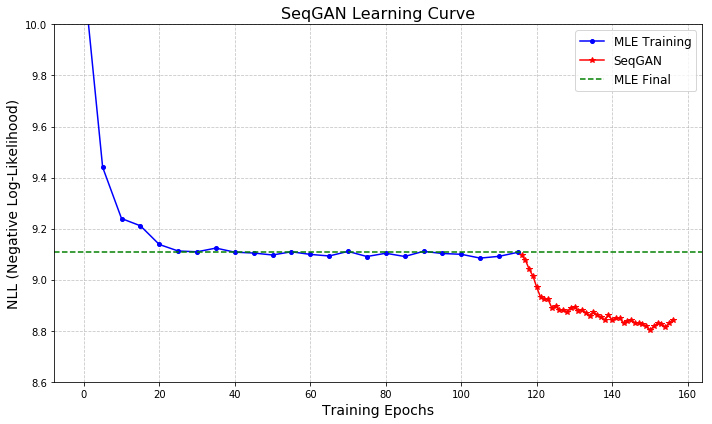

In [24]:
# Create figure similar to the paper (Figure 2)
plt.figure(figsize=(10, 6))

# Plot pre-training (MLE) results
if pre_train_epochs and pre_train_nlls:
    plt.plot(pre_train_epochs, pre_train_nlls, 'b-', marker='o', markersize=4, label='MLE Training')

# Plot adversarial training results
if adv_train_epochs and adv_train_nlls:
    # Offset adversarial training epochs to continue from pre-training
    if pre_train_epochs:
        last_pre_train_epoch = pre_train_epochs[-1]
        adv_train_epochs_adjusted = [last_pre_train_epoch + i + 1 for i in range(len(adv_train_epochs))]
    else:
        adv_train_epochs_adjusted = adv_train_epochs
    
    plt.plot(adv_train_epochs_adjusted, adv_train_nlls, 'r-', marker='*', markersize=6, label='SeqGAN')

# Add horizontal lines for baseline methods if you have their values
if pre_train_nlls:
    plt.axhline(y=pre_train_nlls[-1], color='g', linestyle='--', label='MLE Final')

# Properly label the graph
plt.xlabel('Training Epochs', fontsize=14)
plt.ylabel('NLL (Negative Log-Likelihood)', fontsize=14)
plt.title('SeqGAN Learning Curve', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# If you want to match the exact style from the paper
plt.ylim(8.6, 10.0)  # Adjust based on your actual data range
plt.tight_layout()

# Save the figure
plt.savefig('seqgan_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

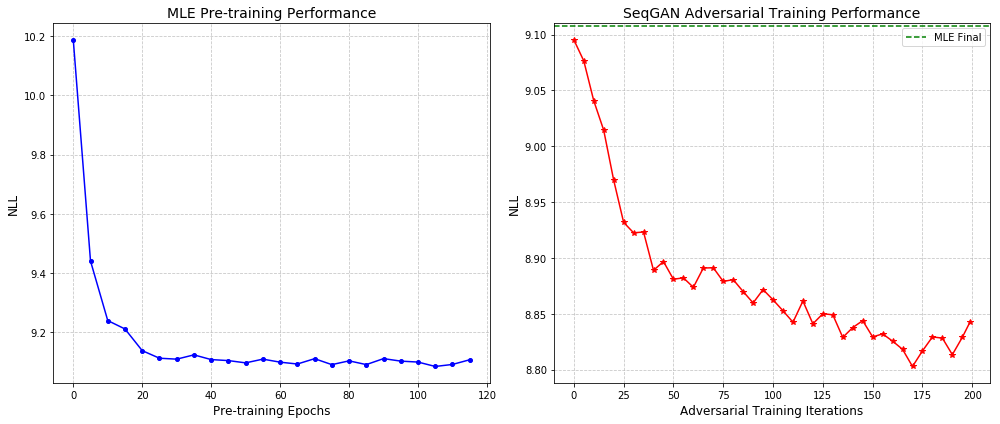

In [25]:
# For a more detailed view, also create separate plots for pre-training and adversarial training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pre-training plot
if pre_train_epochs and pre_train_nlls:
    ax1.plot(pre_train_epochs, pre_train_nlls, 'b-', marker='o', markersize=4)
    ax1.set_xlabel('Pre-training Epochs', fontsize=12)
    ax1.set_ylabel('NLL', fontsize=12)
    ax1.set_title('MLE Pre-training Performance', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)

# Adversarial training plot
if adv_train_epochs and adv_train_nlls:
    ax2.plot(adv_train_epochs, adv_train_nlls, 'r-', marker='*', markersize=6)
    if pre_train_nlls:
        ax2.axhline(y=pre_train_nlls[-1], color='g', linestyle='--', label='MLE Final')
    ax2.set_xlabel('Adversarial Training Iterations', fontsize=12)
    ax2.set_ylabel('NLL', fontsize=12)
    ax2.set_title('SeqGAN Adversarial Training Performance', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

plt.tight_layout()
plt.savefig('seqgan_detailed_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Calculate improvement statistics
if pre_train_nlls and adv_train_nlls:
    pre_train_final_nll = pre_train_nlls[-1]
    adv_train_final_nll = adv_train_nlls[-1]
    
    improvement = pre_train_final_nll - adv_train_final_nll
    percentage_improvement = (improvement / pre_train_final_nll) * 100
    
    print("Performance Summary:")
    print("====================")
    print("Pre-training final NLL: {:.4f}".format(pre_train_final_nll))
    print("Adversarial training final NLL: {:.4f}".format(adv_train_final_nll))
    print("Absolute improvement: {:.4f}".format(improvement))
    print("Percentage improvement: {:.2f}%".format(percentage_improvement))

Performance Summary:
Pre-training final NLL: 9.1073
Adversarial training final NLL: 8.8430
Absolute improvement: 0.2642
Percentage improvement: 2.90%
